# A Star Search Algorithm

### Import the Graph Library and Other Utilities

In [3]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))

sys.path.append(parent_dir)

from assignment_1.lib.graph import Graph
from assignment_1.lib.load_romanian_cities import load_romania
from assignment_1.lib.matplotlib_util import stack_plot

<h3>Algorithm Implementation</h3>

In [14]:
from heapq import heapify, heappop, heappush
import math

def heuristic_function(graph, node1, node2):
    return math.sqrt( (graph[node1][0][0] - graph[node2][0][0]) ** 2 + (graph[node1][0][1] - graph[node2][0][1]) ** 2 )

def a_star_search(graph: Graph, start: str, goal: str) -> bool:
    # sanity check to make sure both nodes exist on the graph.
    if start not in graph or goal not in graph:
        raise ValueError("The start and/or the goal nodes do not exist on the graph.")
    
    visited = set([start])

    curr_node = start
    fringe = [ (heuristic_function(graph, start, goal), start, [start], 0,) ]
    heapify(fringe)

    while fringe:
        _, curr_node, curr_path, curr_cost = heappop(fringe)

        if curr_node == goal:
            return curr_path

        visited.add(curr_node)

        for neighbour, weight in graph.get_neighbours(curr_node):
            if neighbour not in visited:
                new_path = curr_path + [neighbour]
                new_cost = weight + curr_cost
                heuristic = heuristic_function(graph, neighbour, goal) + new_cost

                heappush(fringe, tuple([heuristic, neighbour, new_path, new_cost]))

    return

#### A, B, C. The benchmark should be finding the path between each node. Randomly pick 10 cities. Find the path between them.

In [5]:
import timeit
from random import shuffle

# load romanian cities from the book and the file and set them up to choose 10 random cities
romania: Graph = load_romania()
romanian_cities: list[str] = romania.get_nodes()
shuffle(romanian_cities)
random_cities: list[str] = romanian_cities[:10]

# create variables to hold the total time and total path length for the experiemnt
total_time = 0
total_path_length = 0

# find the path between the cities
for city1 in random_cities:
    for city2 in random_cities:
        if city1 is not city2:
            # get ahold of the path and time taken for each experiment
            path = a_star_search(romania, city1, city2)
            time_taken = timeit.timeit(lambda: a_star_search(romania, city1, city2), number=10)

            total_time += time_taken
            total_path_length += len(path)

# Print the average time and path length recorded
number_of_experiments = 90 # 10 cities, we try to find path between one city with the rest 9
average_time = total_time / number_of_experiments
average_path_length = total_path_length / number_of_experiments

print(f"Average Time: {average_time}")
print(f"Average Path Length: {average_path_length}")


Average Time: 0.0015360454219464576
Average Path Length: 5.177777777777778


#### D. Create random graphs with a number of nodes n = 10, 20, 30, 40. Randomly connect nodes with the probability of edges p = 0.2, 0.4, 0.6, 0.8. In total, you will have 16 graphs.

##### Random Graph and Random Edge Generation Code

In [6]:
import random

def create_random_graph(num_nodes: int) -> Graph:
    new_graph = Graph()
    
    # add all nodes to the new_graph
    for i in range(num_nodes):
        # latitudes range between -90 and 90, so generate a random integer between 0 and 1, multiply it by 90, and then multiply it by 1 or -1 to make it positive or negative
        latitude = random.random() * 90 * random.choice([1, -1])
        # longitudes range between -180 and 180, so generate a random integer between 0 and 1, multiply it by 180, and then multiply it by 1 or -1 to make it positive or negative
        longitude = random.random() * 180 * random.choice([1, -1])
        
        new_graph.add_node(f"{i}", latitude, longitude)
    
    return new_graph

def insert_random_edges(graph: Graph, edge_prob: float) -> Graph:
    nodes = graph.get_nodes()
    num_nodes = len(nodes)
    # randomly connect nodes with probability edge_prob
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if random.random() < edge_prob:
                weight = random.randint(1, 10)
                graph.insert_edge(nodes[i], nodes[j], weight)
    
    return graph


##### Use the random graph generators and do the experiments

In [7]:
from random import shuffle
import timeit

# find all experiment graphs
experiment_graphs = []

# create the graphs with the random number of edges
graphs = [create_random_graph(10), create_random_graph(20), create_random_graph(30), create_random_graph(40)]

for graph in graphs:
    for edge_prob in [ 0.2, 0.4, 0.6, 0.8]:
        edges_added_graph = insert_random_edges(graph.get_copy(), edge_prob)
        experiment_graphs.append((f"{len(graph.get_nodes())}, {edge_prob}", edges_added_graph))

# take the nodes from the first graph which only has 10 nodes, and pick five of them to run all experiments with
nodes = experiment_graphs[0][1].get_nodes()
shuffle(nodes)
random_5_nodes = nodes[:5]

# run and record the results in a dictionary
results = {}

for label, graph in experiment_graphs:
    results[label] = {}

    for node1 in random_5_nodes:
        for node2 in random_5_nodes:
            if node1 is not node2:
                path = a_star_search(graph, node1, node2)
                time_taken = timeit.timeit(lambda: a_star_search(graph, node1, node2), number=5)

                results[label][f"{node1} to {node2}"] = (time_taken * 1000, path)

##### Code for graph visualizer, to visualize the generated graphs with their edges

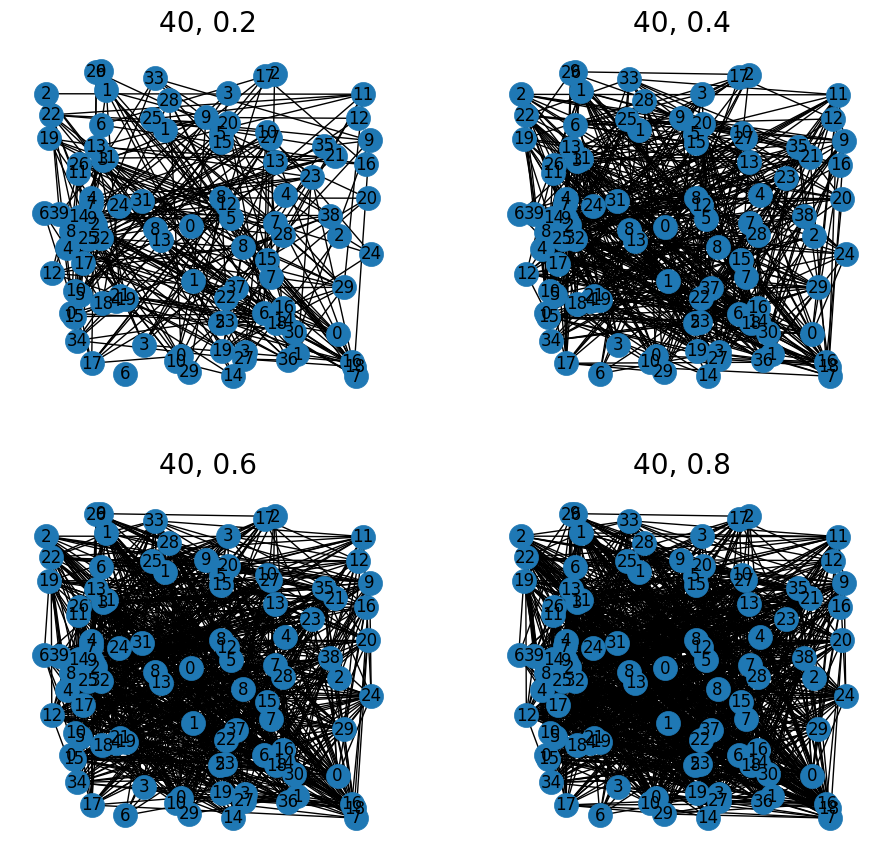

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Iterate over the experiment graphs and plot them
for k in range(1, 5):
    for (i, j), (label, experiment_graph) in zip([(0, 0), (0, 1), (1, 0), (1, 1), (0, 0), (0, 1), (1, 0), (1, 1), (0, 0), (0, 1), (1, 0), (1, 1), (0, 0), (0, 1), (1, 0), (1, 1)], experiment_graphs):
        if label.startswith(f"{k}0"):
            data = experiment_graph.graph

            # Create an empty graph
            G = nx.Graph()

            # Add nodes with their location as the node label
            for node, (location, edges) in data.items():
                G.add_node(node, pos=location)

            # Add edges
            for node, (location, edges) in data.items():
                for target_node, weight in edges.items():
                    G.add_edge(node, target_node, weight=weight)

            # Get node positions from their labels
            node_pos = nx.get_node_attributes(G, 'pos')

            # Draw the graph on the appropriate subplot
            nx.draw(G, pos=node_pos, with_labels=True, ax=axs[i][j])
            axs[i][j].set_title(label)

    # Save the figures
    plt.savefig(f'output/experiment_graphs_{k}0_nodes.png', format='png')


## Plot the graphs using matplotlib.pyplot

#### A. Plot the time taken

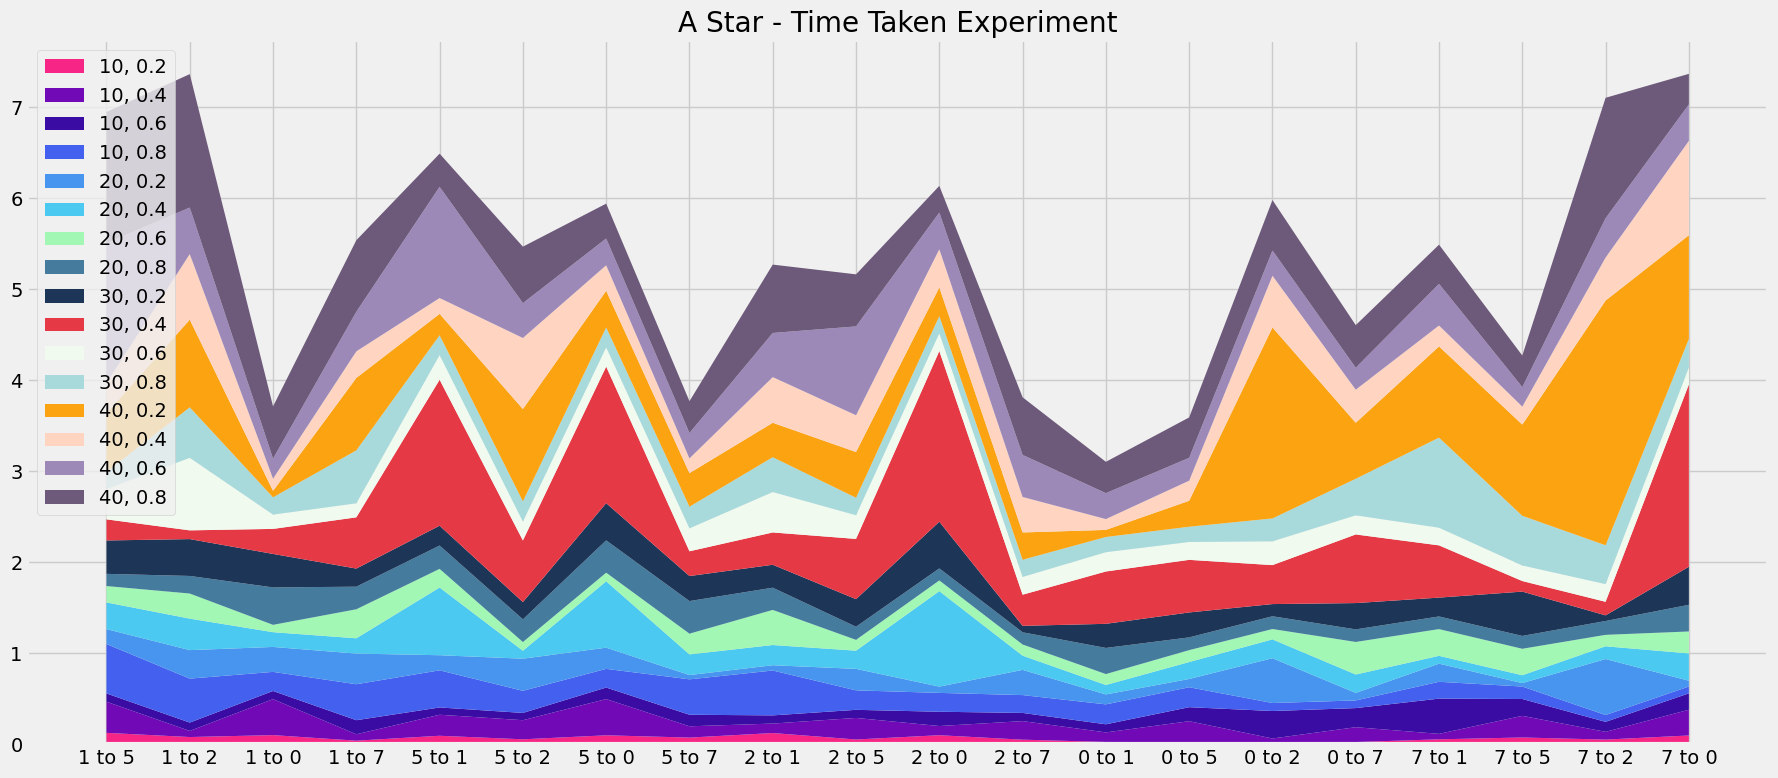

In [12]:
import matplotlib.pyplot as plt

# Define the plot titles for each subplot pair
plt.style.use('fivethirtyeight')

nodes = list(results['10, 0.2'].keys())
labels = []
time_taken = []

for i, (label, result) in enumerate(results.items()):
    labels.append(label)
    time_taken.append(list(round(time, 3) for time, path in result.values()))

stack_plot("A* - Time Taken Experiment", nodes, time_taken, labels)

#### A. Plot the solution path length

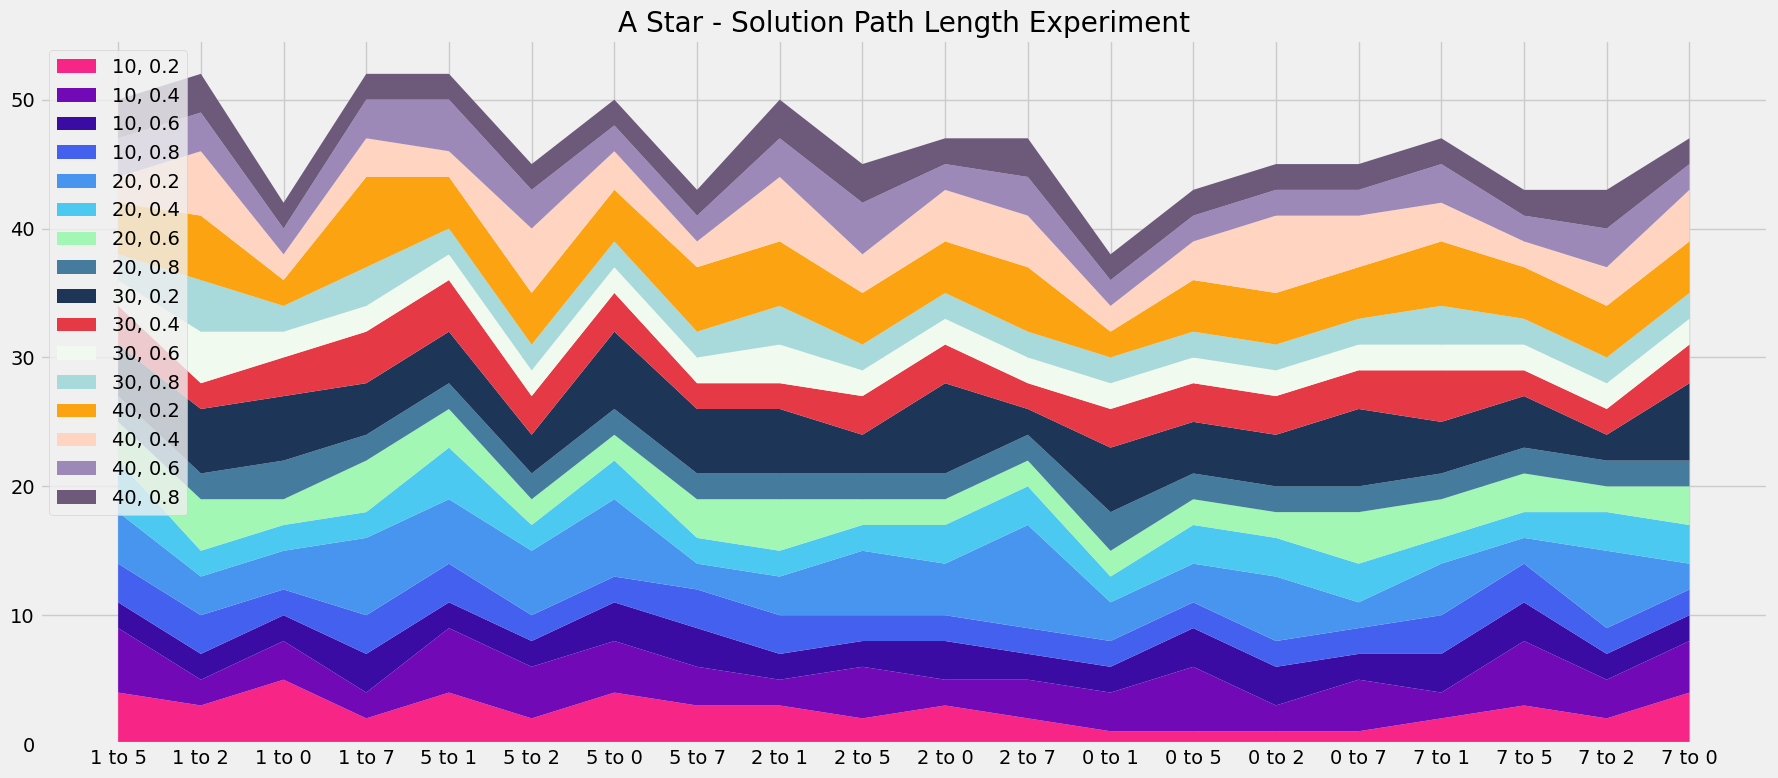

In [11]:
import matplotlib.pyplot as plt

# Define the plot titles for each subplot pair
plt.style.use('fivethirtyeight')

nodes = list(results['10, 0.2'].keys())
labels = []
path_length = []

for i, (label, result) in enumerate(results.items()):
    labels.append(label)
    path_length.append(list(len(path) for time, path in result.values()))

stack_plot("A* - Solution Path Length Experiment", nodes, path_length, labels)